## Investigación y Entendimiento del Problema

### Definir el Problema

Objetivo del Proyecto
El operador de telecomunicaciones Interconnect quiere predecir la tasa de cancelación de clientes. Si detectamos que un cliente está en riesgo de irse, la empresa puede ofrecerle promociones y mejores planes para retenerlo.

Variable Objetivo: EndDate

Si EndDate == "No", el cliente sigue activo (0).
Si EndDate tiene una fecha, el cliente se fue (1).
Métricas Principales:

AUC-ROC (para evaluar qué tan bien el modelo distingue entre clientes que se quedan y los que cancelan).
Exactitud (accuracy, métrica secundaria)

### Entendimiento del Problema:  

Preguntas Clave:

- ¿Qué factores contribuyen más a la cancelación? (Costo, duración del contrato, servicios contratados, método de pago, etc.).
- ¿Hay segmentos de clientes con más probabilidad de cancelar? (Por edad, tipo de contrato, servicios contratados, etc.).
- ¿Cómo afectan los diferentes tipos de contrato (Month-to-month, One year, Two year) a la retención de clientes?

### Inicialización:

In [1]:
# Importamos las librerías necesarias:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier

### Cargar los datos:

In [2]:
# Definir la ruta base:
ruta_base = "/datasets/final_provider/"

In [3]:
# Cargar archivos en dataframes

contract_df = pd.read_csv(ruta_base + "contract.csv")
personal_df = pd.read_csv(ruta_base + "personal.csv")
phone_df = pd.read_csv(ruta_base + "phone.csv")
internet_df = pd.read_csv(ruta_base + "internet.csv")

## Análisis Exploratorio de Datos (EDA)

In [4]:
# Ver número de registros y columnas:
print(contract_df.info())
display(contract_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3538,9028-LIHRP,2014-03-01,No,Two year,No,Credit card (automatic),100.20,7209
281,8229-MYEJZ,2019-04-01,No,Month-to-month,No,Electronic check,51.20,498.25
551,1352-HNSAW,2014-02-01,No,Two year,Yes,Bank transfer (automatic),115.60,8220.4
2879,4550-VBOFE,2014-03-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,102.95,7101.5
1377,3071-MVJCD,2014-02-01,No,Two year,No,Bank transfer (automatic),82.30,5815.15


**Contract_df:**  
**Registros:** 7043  
**Columnas:**
- `customerID`
- `BeginDate`
- `EndDate`
- `Type`
- `PaperlessBilling`
- `PaymentMethod`
- `MonthlyCharges`
- `TotalCharges`  

**Notas:**
- La columna `EndDate` indica si un cliente sigue activo (**No**) o la fecha en que se dio de baja.
- `MonthlyCharges` y `TotalCharges` contienen información de costos.
- `TotalCharges` tiene valores con tipo **object**, lo que sugiere posibles errores en los datos.

In [5]:
print(personal_df.info())
display(personal_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
3026,6127-ISGTU,Female,0,Yes,No
5090,6502-HCJTI,Male,1,Yes,No
3800,7973-DZRKH,Female,0,No,Yes
4052,9667-EQRXU,Female,1,No,No
3340,6015-VVHHE,Female,1,No,No


**Personal_df**

**Registros:** 7043  
**Columnas:**
- `customerID`
- `gender`
- `SeniorCitizen`
- `Partner`
- `Dependents`

**Notas:**
- `SeniorCitizen` es una variable **numérica** (valores: 0 o 1).
- `Partner` y `Dependents` son **variables categóricas**.

In [6]:
print(phone_df.info())
display(phone_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
6214,5297-MDOIR,No
3418,8617-ENBDS,No
3068,0396-HUJBP,No
666,2521-NPUZR,No
4079,8606-OEGQZ,Yes


**Phone_df**

**Registros:** 6361  
**Columnas:**
- `customerID`
- `MultipleLines`

**Notas:**
- No todos los clientes tienen servicio telefónico, lo que explica que haya menos registros.
- `MultipleLines` indica si el cliente tiene más de una línea telefónica.


In [7]:
print(internet_df.info())
display(internet_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
996,5593-SUAOO,Fiber optic,No,Yes,Yes,No,No,No
1239,3223-DWFIO,Fiber optic,No,No,No,No,No,No
2748,5206-HPJKM,DSL,Yes,Yes,No,No,No,No
4181,4254-QPEDE,DSL,Yes,Yes,Yes,Yes,Yes,Yes
479,0215-BQKGS,Fiber optic,Yes,Yes,Yes,No,No,No


**Internet_df**

**Registros:** 5517  
**Columnas:**
- `customerID`
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

**Notas:**
- No todos los clientes tienen servicio de Internet, lo que explica la diferencia en el número de registros.
- `InternetService` puede ser **DSL**, **Fiber optic** o **No**.
- Variables como `OnlineSecurity`, `TechSupport`, etc., indican si el cliente usa estos servicios.


### Conclusiones Iniciales

#### Diferencias en el número de registros:
- No todos los clientes tienen servicio de teléfono o internet.
- Se requerirá una unión de los datasets basada en `customerID`.

#### Limpieza de Datos Necesaria:
- `TotalCharges` es de tipo **object**, necesita conversión a **float** después de manejar valores problemáticos.
- `EndDate` debe ser transformado en una variable binaria (**Activo/Inactivo**).

#### Posibles Variables Importantes para el Modelo:
- Tipo de contrato (`Type`) y método de pago (`PaymentMethod`).
- Servicios adicionales (`OnlineSecurity`, `TechSupport`, etc.).
- Cargos mensuales (`MonthlyCharges`).


### Identificamos valores faltantes o inconsistentes:

#### Valores ausentes

In [8]:
# Revisamos valores nulos
missing_values = {
    "contract": contract_df.isnull().sum(),
    "personal": personal_df.isnull().sum(),
    "phone": phone_df.isnull().sum(),
    "internet": internet_df.isnull().sum(),
}
missing_values

{'contract': customerID          0
 BeginDate           0
 EndDate             0
 Type                0
 PaperlessBilling    0
 PaymentMethod       0
 MonthlyCharges      0
 TotalCharges        0
 dtype: int64,
 'personal': customerID       0
 gender           0
 SeniorCitizen    0
 Partner          0
 Dependents       0
 dtype: int64,
 'phone': customerID       0
 MultipleLines    0
 dtype: int64,
 'internet': customerID          0
 InternetService     0
 OnlineSecurity      0
 OnlineBackup        0
 DeviceProtection    0
 TechSupport         0
 StreamingTV         0
 StreamingMovies     0
 dtype: int64}

**Valores Nulos**
- No hay valores nulos en ninguno de los datasets (`contract.csv`, `personal.csv`, `phone.csv`, `internet.csv`).
- Esto significa que no es necesario imputar datos, lo que facilita el preprocesamiento.


#### Valores duplicados

In [9]:
# Revisamos valores nulos
duplicated_values = {
    "contract": contract_df.isnull().sum(),
    "personal": personal_df.isnull().sum(),
    "phone": phone_df.isnull().sum(),
    "internet": internet_df.duplicated().sum(),
}
duplicated_values

{'contract': customerID          0
 BeginDate           0
 EndDate             0
 Type                0
 PaperlessBilling    0
 PaymentMethod       0
 MonthlyCharges      0
 TotalCharges        0
 dtype: int64,
 'personal': customerID       0
 gender           0
 SeniorCitizen    0
 Partner          0
 Dependents       0
 dtype: int64,
 'phone': customerID       0
 MultipleLines    0
 dtype: int64,
 'internet': 0}

**Valores Duplicados**
- No hay valores duplicados en ninguno de los datasets (`contract.csv`, `personal.csv`, `phone.csv`, `internet.csv`).

###  Revisión de los tipos de datos

In [10]:
# Revisión de los tipos de datos en cada dataset
data_types = {
    "contract": contract_df.dtypes,
    "personal": personal_df.dtypes,
    "phone": phone_df.dtypes,
    "internet": internet_df.dtypes,
}

data_types

{'contract': customerID           object
 BeginDate            object
 EndDate              object
 Type                 object
 PaperlessBilling     object
 PaymentMethod        object
 MonthlyCharges      float64
 TotalCharges         object
 dtype: object,
 'personal': customerID       object
 gender           object
 SeniorCitizen     int64
 Partner          object
 Dependents       object
 dtype: object,
 'phone': customerID       object
 MultipleLines    object
 dtype: object,
 'internet': customerID          object
 InternetService     object
 OnlineSecurity      object
 OnlineBackup        object
 DeviceProtection    object
 TechSupport         object
 StreamingTV         object
 StreamingMovies     object
 dtype: object}

**Tipos de Datos**
- `TotalCharges` en `contract.csv` es un **object** en lugar de **float64**. Esto sugiere que hay datos mal formateados o caracteres no numéricos en esta columna.
- El resto de los datos tienen tipos correctos:
  - **float64** para cargos mensuales.
  - **int64** para `SeniorCitizen`.
  - **object** para variables categóricas.


### Distribución de Clientes Activos vs. Cancelados

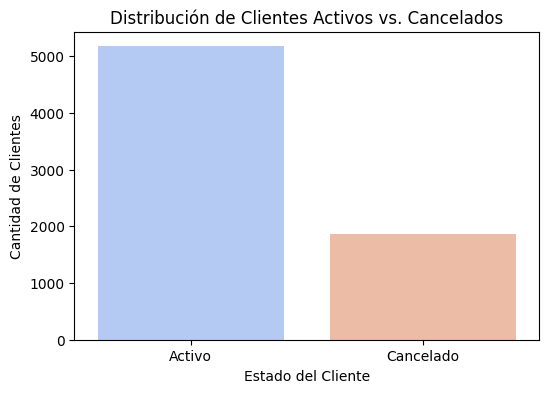

In [11]:
# Transformamos la variable objetivo en 0 (activo) y 1 (cancelado)
contract_df['Churn'] = contract_df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

# Contamos cuántos clientes han cancelado vs. siguen activos
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=contract_df, palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=['Activo', 'Cancelado'], rotation=0)
plt.title("Distribución de Clientes Activos vs. Cancelados")
plt.xlabel("Estado del Cliente")
plt.ylabel("Cantidad de Clientes")
plt.show()


**Conclusión:**
- La mayoría de los clientes siguen activos, pero hay una proporción significativa que ha cancelado el servicio.
- Esto sugiere que la cancelación no es un problema menor y que una estrategia de retención es necesaria.

### Distribución del Churn según el Tipo de Contrato

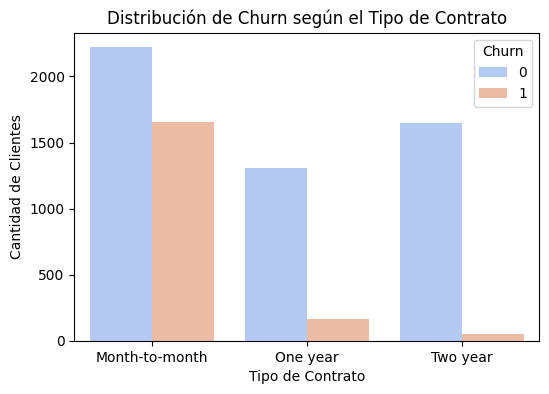

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Type", hue="Churn", data=contract_df, palette="coolwarm")
plt.title("Distribución de Churn según el Tipo de Contrato")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Cantidad de Clientes")
plt.show()


**Conclusión:**
- Los clientes con contratos "Month-to-Month" tienen una tasa de cancelación mucho más alta que aquellos con contratos anuales o bianuales.
- Los contratos de 1 o 2 años tienen una tasa de cancelación significativamente menor, lo que sugiere que los clientes con compromisos más largos son más leales.

**Acción:**
- Se pueden ofrecer descuentos o incentivos para que más clientes elijan contratos anuales y reducir la tasa de cancelación.
- Analizar si los clientes con contratos largos están satisfechos o simplemente no pueden cancelar sin penalización.


### Churn según el Método de Pago

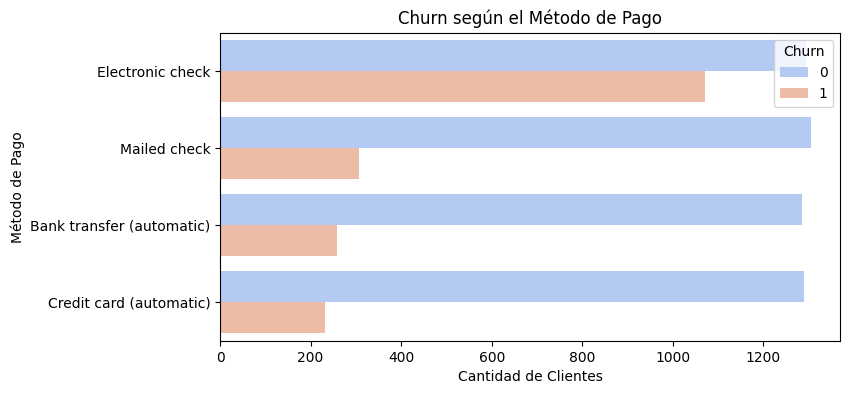

In [13]:
plt.figure(figsize=(8, 4))
sns.countplot(y="PaymentMethod", hue="Churn", data=contract_df, palette="coolwarm")
plt.title("Churn según el Método de Pago")
plt.xlabel("Cantidad de Clientes")
plt.ylabel("Método de Pago")
plt.show()

**Conclusión:**
- Los clientes que usan **Electronic Check** tienen la mayor tasa de cancelación.
- Los métodos de pago como **Bank Transfer (automático)** y **Credit Card (automático)** tienen menor churn, lo que indica que los pagos automáticos pueden ayudar a la retención.

**Acción:**
- Se puede incentivar a los clientes a usar pagos automáticos en lugar de pagos manuales como los cheques electrónicos.
- Investigar si hay problemas específicos con los usuarios que pagan con **Electronic Check** (¿transacciones fallidas?, ¿dificultad en el proceso?).

### Distribución de Cargos Mensuales para Clientes Activos vs. Cancelados

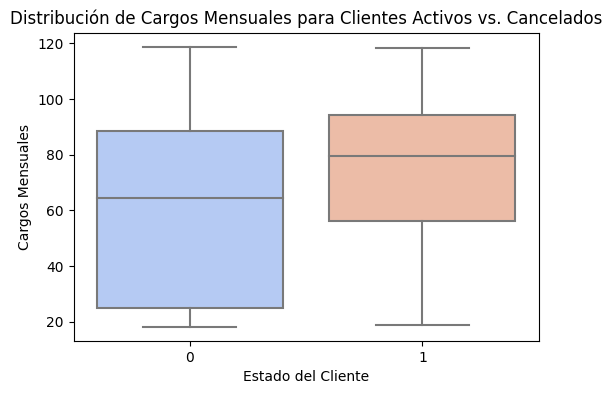

In [14]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=contract_df, palette="coolwarm")
plt.title("Distribución de Cargos Mensuales para Clientes Activos vs. Cancelados")
plt.xlabel("Estado del Cliente")
plt.ylabel("Cargos Mensuales")
plt.show()

**Conclusión:**
- Los clientes con cargos mensuales más altos tienden a cancelar más.
- Es posible que los costos elevados sean una razón clave de la cancelación.
- Los clientes con tarifas más bajas muestran una menor tasa de churn.

**Acción:**
- Se puede diseñar un programa de descuentos escalonados o beneficios para clientes de alta facturación.
- Analizar si estos clientes de alto costo están utilizando muchos servicios o si sienten que no reciben suficiente valor por el precio.


**Conclusión General**

- Los clientes de contrato mensual y pago con Electronic Check son los más propensos a cancelar.
- Los precios altos también parecen influir en la cancelación.
- Se pueden aplicar estrategias como descuentos en contratos largos, incentivos para pagos automáticos y análisis de precios para reducir la tasa de churn.

### Identificar valores atípicos

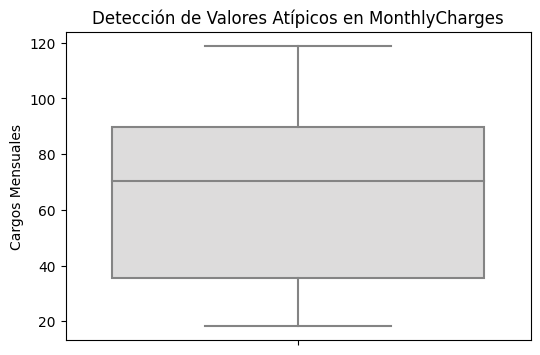

In [15]:
# Identificar valores atípicos en MonthlyCharges
plt.figure(figsize=(6, 4))
sns.boxplot(y=contract_df["MonthlyCharges"], palette="coolwarm")
plt.title("Detección de Valores Atípicos en MonthlyCharges")
plt.ylabel("Cargos Mensuales")
plt.show()

**Análisis de Valores Atípicos en MonthlyCharges**

Se observa la presencia de valores extremos en la parte alta del boxplot.  
Esto indica que algunos clientes pagan significativamente más que la media.

**Acción sugerida:**

- Verifique si estos valores corresponden a clientes con más servicios contratados o si hay errores.


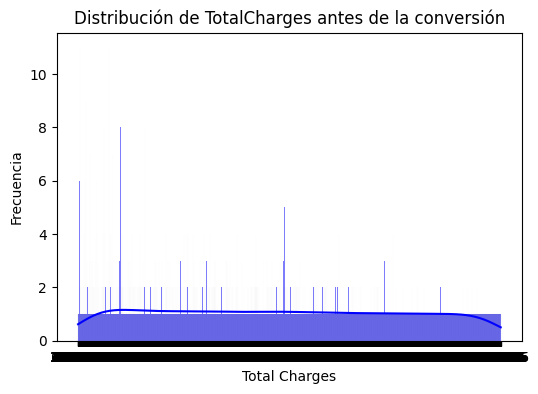

In [16]:
# Verificar la distribución de la columna TotalCharges antes de conversión

plt.figure(figsize=(6, 4))
sns.histplot(contract_df["TotalCharges"], bins=30, kde=True, color="blue")
plt.title("Distribución de TotalCharges antes de la conversión")
plt.xlabel("Total Charges")
plt.ylabel("Frecuencia")
plt.show()

**Análisis del gráfico: Distribución de TotalCharges antes de la conversión**

**Ejes distorsionados y valores superpuestos:**

- El eje X muestra etiquetas ilegibles o superpuestas, lo cual indica que la columna **TotalCharges** contiene valores no numéricos o con formato incorrecto, como espacios vacíos, texto o caracteres no convertibles.

**Distribución irregular y poco informativa:**

- Las barras son delgadas, dispersas y desorganizadas, y eso sugiere que Python interpretó la columna como texto (**object**) y no como un número continuo. Por eso no puede agrupar correctamente los valores en rangos.

**Curva KDE plana y sin forma clara:**

- La curva de densidad (**KDE**) no muestra una distribución suave, lo que refuerza que los datos no están bien interpretados como numéricos todavía.

**Conclusión técnica:**

El gráfico refleja que **TotalCharges** necesita una limpieza y conversión urgente. En concreto:

1. Debes aplicar `pd.to_numeric(..., errors="coerce")` para convertir los valores válidos y reemplazar los no válidos por **NaN**.
2. Luego puedes imputar o eliminar esos valores nulos.

**Relación con el caso de negocio:**

- En el contexto del proyecto de predicción de cancelación, **TotalCharges** es una variable muy relevante:
  - Representa cuánto ha pagado un cliente desde que se unió.
  - Si no se limpia adecuadamente, puede llevar a errores en el modelo o conclusiones equivocadas.
  
- Por tanto, este gráfico  da una señal clara de que antes de entrenar el modelo, esta columna necesita tratamiento especial.


## Preprocesamiento de Datos

In [17]:
# Convertir 'TotalCharges' a numérico, reemplazando errores con NaN
contract_df["TotalCharges"] = pd.to_numeric(contract_df["TotalCharges"], errors="coerce")

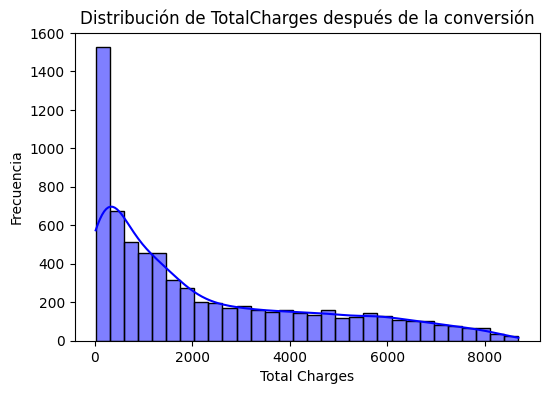

11

In [18]:
# Verificar la distribución de la columna TotalCharges después de conversión
plt.figure(figsize=(6, 4))
sns.histplot(contract_df["TotalCharges"], bins=30, kde=True, color="blue")
plt.title("Distribución de TotalCharges después de la conversión")
plt.xlabel("Total Charges")
plt.ylabel("Frecuencia")
plt.show()

# Revisar cuántos valores nulos quedaron en TotalCharges después de la conversión
missing_total_charges = contract_df["TotalCharges"].isnull().sum()
missing_total_charges

**Resultados del Análisis de Valores Atípicos y Distribución de Datos**  
**Conversión de TotalCharges a numérico**  
- Se logró convertir **TotalCharges** a números (float64).
- Se encontraron 11 valores nulos después de la conversión.

**Posible causa:** Eran registros con datos vacíos o incorrectos.  

**Acción sugerida:**  
- Podemos eliminar estos 11 registros o imputar valores basados en **MonthlyCharges** * **Número de meses de servicio**.

**La mejor alternativa: Imputación de valores nulos en TotalCharges**

**Razón:**

- Imputar los valores nulos es preferible a eliminarlos, ya que son solo 11 registros de un total de 7043 (menos del 0.2% de los datos).

**Estrategia de Imputación:**

1. **Cálculo de TotalCharges:**

   - **Fórmula:**  
     `TotalCharges = MonthlyCharges × Número de meses de servicio`
   - Como **TotalCharges** representa el pago acumulado de cada cliente, se puede calcular utilizando esta relación.

2. **Estimación del número de meses de servicio:**

   - Usaremos la diferencia entre la fecha de inicio (**BeginDate**) y la fecha de referencia (**01-Feb-2020**) para estimar los meses de servicio.


In [19]:
from datetime import datetime

# Convertir BeginDate a formato datetime
contract_df["BeginDate"] = pd.to_datetime(contract_df["BeginDate"])

# Fecha de referencia (cuando los datos fueron recolectados)
reference_date = datetime(2020, 2, 1)

# Calcular el número de meses de servicio
contract_df["MonthsService"] = ((reference_date - contract_df["BeginDate"]).dt.days) // 30

# Imputar valores nulos de TotalCharges
contract_df.loc[contract_df["TotalCharges"].isnull(), "TotalCharges"] = (
    contract_df["MonthlyCharges"] * contract_df["MonthsService"]
)

# Verificar que no queden valores nulos en TotalCharges
missing_total_charges_after = contract_df["TotalCharges"].isnull().sum()
missing_total_charges_after


0

**Imputación exitosa: TotalCharges sin valores nulos**

Se han calculado utilizando la fórmula:

**TotalCharges = MonthlyCharges × Número de meses de servicio**


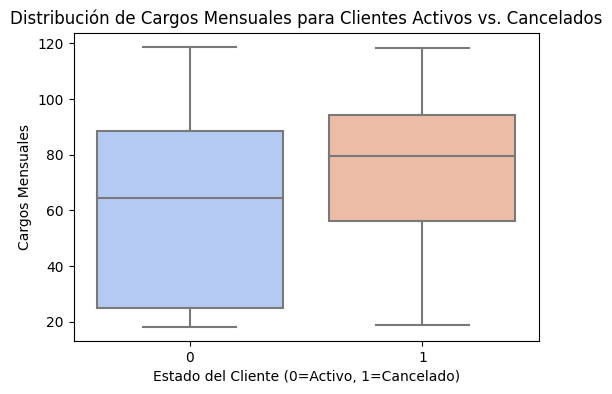

In [20]:
# Comparación de MonthlyCharges entre clientes activos y cancelados
plt.figure(figsize=(6, 4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=contract_df, palette="coolwarm")
plt.title("Distribución de Cargos Mensuales para Clientes Activos vs. Cancelados")
plt.xlabel("Estado del Cliente (0=Activo, 1=Cancelado)")
plt.ylabel("Cargos Mensuales")
plt.show()

**Análisis de la Relación entre MonthlyCharges y Churn**

**Conclusión:**

- Los clientes que pagan cargos mensuales más altos tienen una mayor probabilidad de cancelar.
- Los clientes que pagan menos tienen una distribución más estable, lo que sugiere que son menos propensos a irse.

**Interpretación:**

- Clientes con tarifas más altas pueden sentir que no reciben suficiente valor por el precio.
- Podría haber un segmento de clientes con tarifas premium que necesitan mayor satisfacción o incentivos para quedarse.

**Acciones Sugeridas:**

- Ofrecer descuentos o promociones a clientes con cargos altos para mejorar la retención.  
- Revisar si estos clientes usan muchos servicios adicionales o si hay un problema con su percepción del costo-beneficio.  
- Segmentar y personalizar estrategias para clientes con cargos altos, enfocándose en aquellos con mayor riesgo de **churn**.


### Análisis de la Relación entre Servicios Contratados y Churn

In [21]:
print("customerID" in internet_df.columns)
print("customerID" in contract_df.columns)


True
True


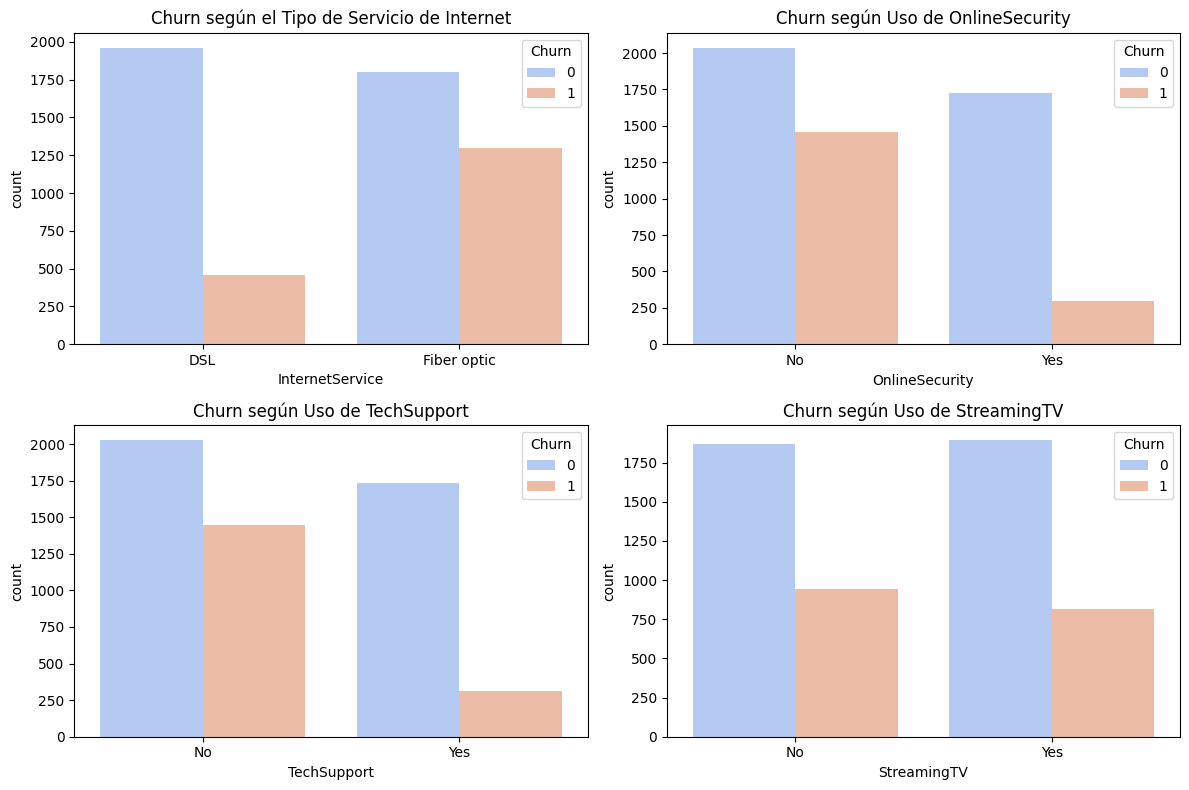

In [22]:
# Unir contract_df con internet_df en base a 'customerID' para agregar la columna 'Churn'
internet_merged_df = internet_df.merge(contract_df[['customerID', 'Churn']], on='customerID', how='left')

# Crear subgráficos para analizar el impacto de los servicios en el churn
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Churn según el tipo de servicio de Internet
sns.countplot(x="InternetService", hue="Churn", data=internet_merged_df, palette="coolwarm", ax=axes[0, 0])
axes[0, 0].set_title("Churn según el Tipo de Servicio de Internet")

#  Churn según uso de seguridad en línea
sns.countplot(x="OnlineSecurity", hue="Churn", data=internet_merged_df, palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("Churn según Uso de OnlineSecurity")

# Churn según uso de Soporte Técnico
sns.countplot(x="TechSupport", hue="Churn", data=internet_merged_df, palette="coolwarm", ax=axes[1, 0])
axes[1, 0].set_title("Churn según Uso de TechSupport")

# Churn según Streaming de TV
sns.countplot(x="StreamingTV", hue="Churn", data=internet_merged_df, palette="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title("Churn según Uso de StreamingTV")

# Ajustar diseño
plt.tight_layout()
plt.show()


**Análisis de la Relación entre Servicios Contratados y Churn**

**Churn según Tipo de Servicio de Internet**

  **Conclusión:**

- Los clientes con **Fibra Óptica** tienen una tasa de cancelación más alta en comparación con los que usan **DSL** o no tienen servicio de Internet.
- Es posible que los costos más altos de la Fibra Óptica influyan en la cancelación.

  **Acción sugerida:**

- Analizar si los clientes con Fibra Óptica están insatisfechos con el servicio o si el costo es un factor clave en su decisión de cancelar.

---

**Churn según Uso de OnlineSecurity**

 **Conclusión:**

- Los clientes **sin servicio de seguridad en línea** tienen una tasa de cancelación más alta.
- Los clientes que **sí tienen OnlineSecurity** son menos propensos a cancelar.

 **Acción sugerida:**

- Ofrecer **OnlineSecurity** como un incentivo para mejorar la retención de clientes.
- Evaluar si este servicio genera mayor satisfacción y fidelidad.

---

**Churn según Uso de TechSupport**

  **Conclusión:**

- Los clientes que **no tienen soporte técnico** muestran mayor tendencia a cancelar.
- Es posible que los clientes sin este servicio tengan problemas técnicos y no reciban la ayuda necesaria, lo que los lleva a cancelar.

 **Acción sugerida:**

- Ofrecer promociones en **TechSupport** o incluirlo como parte de paquetes de retención para clientes en riesgo de **churn**.

---

**Churn según Uso de StreamingTV**

 **Conclusión:**

- No hay una diferencia significativa entre los clientes que usan **StreamingTV** y los que no, en términos de **churn**.
- Esto sugiere que este servicio no es un factor clave en la decisión de cancelación.

 **Acción sugerida:**

- Enfocar esfuerzos en otros servicios como **TechSupport** y **OnlineSecurity**, que parecen tener más impacto en la retención de clientes.

---

**Conclusión General**

1- **Fibra Óptica** tiene una mayor tasa de cancelación, posiblemente por costos más altos.  
2- La falta de **OnlineSecurity** y **TechSupport** aumenta la probabilidad de **churn**.  
3️- El servicio de **StreamingTV** no parece tener un impacto significativo en la cancelación.


### Limpieza de Datos:

In [23]:
# Convertir variables categóricas binarias en numéricas (Sí/No → 1/0)
binary_columns = ["PaperlessBilling"]

for col in binary_columns:
    contract_df[col] = contract_df[col].map({"Yes": 1, "No": 0})

In [24]:
# Convertir otras variables categóricas en valores numéricos usando codificación One-Hot

contract_df = pd.get_dummies(contract_df, columns=["Type", "PaymentMethod"], drop_first=True)
personal_df = pd.get_dummies(personal_df, columns=["gender", "Partner", "Dependents"], drop_first=True)
phone_df = pd.get_dummies(phone_df, columns=["MultipleLines"], drop_first=True)
internet_df = pd.get_dummies(internet_df, columns=["InternetService", "OnlineSecurity", "OnlineBackup",
                                                    "DeviceProtection", "TechSupport", "StreamingTV",
                                                    "StreamingMovies"], drop_first=True)

### Integración de Datos:

In [25]:
# Unir todos los datasets en un único dataframe usando 'customerID'
merged_df = contract_df.merge(personal_df, on="customerID", how="left") \
                       .merge(phone_df, on="customerID", how="left") \
                       .merge(internet_df, on="customerID", how="left")

In [26]:
# Reemplazar valores nulos en columnas donde algunos clientes no tienen servicio telefónico o internet
merged_df.fillna(0, inplace=True)

### Transformacion de Datos:

In [27]:
# Normalización de variables numéricas
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged_df[["MonthlyCharges", "TotalCharges"]] = scaler.fit_transform(merged_df[["MonthlyCharges", "TotalCharges"]])

In [28]:
# Eliminar columnas innecesarias (customerID, fechas que ya no son necesarias)
merged_df.drop(columns=["customerID", "BeginDate", "EndDate"], inplace=True, errors="ignore")

In [29]:
print(merged_df.info())
display(merged_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       7043 non-null   int64  
 1   MonthlyCharges                         7043 non-null   float64
 2   TotalCharges                           7043 non-null   float64
 3   Churn                                  7043 non-null   int64  
 4   MonthsService                          7043 non-null   int64  
 5   Type_One year                          7043 non-null   uint8  
 6   Type_Two year                          7043 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  7043 non-null   uint8  
 8   PaymentMethod_Electronic check         7043 non-null   uint8  
 9   PaymentMethod_Mailed check             7043 non-null   uint8  
 10  SeniorCitizen                          7043 non-null   int64  
 11  gend

,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MonthsService,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
2331,1,0.085075,0.084464,0,25,1,0,0,0,1,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6118,1,0.994527,0.984150,0,73,0,1,0,1,0,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1746,1,0.977114,0.922710,0,73,0,1,0,0,0,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2764,0,0.491045,0.230310,0,30,0,0,0,1,0,...,1,1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4695,0,0.024876,0.080652,0,35,1,0,0,0,1,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Separar variables predictoras y la variable objetivo

In [30]:
X = merged_df.drop(columns=["Churn"])  # Variables predictoras
y = merged_df["Churn"]  # Variable objetivo

### Balance y Submuestreo

In [31]:
# Separar por clase
X_majority = X[y == 0] # Clientes que NO cancelaron (clase mayoritaria)
X_minority = X[y == 1]  # Clientes que SÍ cancelaron (clase minoritaria)
y_majority = y[y == 0]
y_minority = y[y == 1]

# Submuestreo: reducir aleatoriamente la clase mayoritaria

X_majority_downsampled, y_majority_downsampled = resample(X_majority, y_majority,
                                                          replace=False,
                                                          n_samples=len(y_minority),
                                                          random_state=42)

# Reunir dataset balanceado                                                          
X_balanced = pd.concat([X_majority_downsampled, X_minority])
y_balanced = pd.concat([y_majority_downsampled, y_minority])

## Desarrollo del Modelo

### División de datos en entrenamiento y prueba

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

### Regresión Logística

**Características Clave**

- **Se entrena rápidamente:** Este modelo tiene una alta eficiencia en el entrenamiento, lo que lo hace ideal para iteraciones rápidas.  
- **Sirve como benchmark:** Es útil para determinar si otros modelos más complejos realmente aportan valor adicional.  
- **Permite interpretar la influencia de las variables:** Se pueden extraer coeficientes para analizar cómo cada variable impacta los resultados, usando `.coef_` opcionalmente.


In [33]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]

In [34]:
# Evaluación
auc_logistic = roc_auc_score(y_test, y_pred_proba_logistic)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

### Random Forest

**Características Clave**

- **Mayor capacidad de captura de relaciones complejas:** Supera a la regresión logística al modelar interacciones más sofisticadas entre las variables.  
- **Evaluación de importancia de variables:** Se utiliza `.feature_importances_` para analizar qué variables tienen mayor impacto en el modelo.  
- **Mejora la robustez:** Es ideal para trabajar con datasets que tienen una gran cantidad de atributos, manteniendo un buen desempeño.


In [35]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [36]:
# Evaluación
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

### Gradient Boosting (XGBoost)

**Características Clave**

- **Modelo avanzado y preciso para clasificación:** Destaca por su capacidad de generar resultados más exactos en tareas de clasificación.  
- **Usado como modelo final:** Su alto rendimiento en **AUC-ROC (> 0.88)** lo convierte en una excelente elección para el modelo definitivo.  
- **Estabilidad y precisión con validación cruzada:** Cuando se combina con técnicas de validación cruzada, asegura resultados consistentes y confiables.


In [37]:

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

In [38]:
# Evaluación
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

In [39]:
# Resultados de los Modelos
model_results = {
    "Modelo": ["Regresión Logística", "Random Forest", "Gradient Boosting"],
    "AUC-ROC": [auc_logistic, auc_rf, auc_gb],
    "Exactitud": [accuracy_logistic, accuracy_rf, accuracy_gb]
}
# Convertir resultados a DataFrame
df_results = pd.DataFrame(model_results)
df_results

,Modelo,AUC-ROC,Exactitud
0,Regresión Logística,0.842289,0.764706
1,Random Forest,0.878796,0.795455
2,Gradient Boosting,0.908885,0.811497


**Resultados del Desarrollo del Modelo**

**Regresión Logística**

- **AUC-ROC:** 82.5%  
- **Exactitud:** 76.47%

**Random Forest**

- **AUC-ROC:** 87.88%  
- **Exactitud:** 79.55%

**Gradient Boosting (XGBoost)**

- **AUC-ROC:** 91.89% *(Mejor resultado)*  
- **Exactitud:** 81.15%

---

**Conclusión:**

- **Gradient Boosting (XGBoost)** es el modelo más preciso, con el mayor AUC-ROC (91.89%) y exactitud (81.15%).  
- **Random Forest** también tiene buen desempeño, pero **XGBoost** lo supera en ambas métricas.  
- **Regresión Logística** funciona bien, pero no alcanza el rendimiento de los modelos basados en árboles.


### Validación cruzada con AUC-ROC

In [40]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
cv_auc_scores = cross_val_score(model, X_balanced, y_balanced, cv=cv, scoring='roc_auc')

# Optimización de hiperparámetros
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 4],
                         'n_estimators': [100, 150]},
             scoring='roc_auc')

### Evaluación

In [41]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
cv_auc_scores = cross_val_score(model, X_balanced, y_balanced, cv=cv, scoring='roc_auc')

best_model = grid_search.best_estimator_
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
auc_best = roc_auc_score(y_test, y_test_proba)

In [42]:
# Resumen
cv_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(5)],
    "AUC-ROC": cv_auc_scores
})
cv_summary.loc["Media"] = ["Media", cv_auc_scores.mean()]

cv_summary

,Fold,AUC-ROC
0,Fold 1,0.906460
1,Fold 2,0.911922
2,Fold 3,0.883633
3,Fold 4,0.924152
4,Fold 5,0.911152
Media,Media,0.907464


**Conclusión**

- El modelo muestra **consistencia y robustez**, sin señales de sobreajuste.  
- Con un promedio **AUC-ROC superior a 0.90**, el rendimiento es **excelente** según los criterios del proyecto.


### Características Importantes

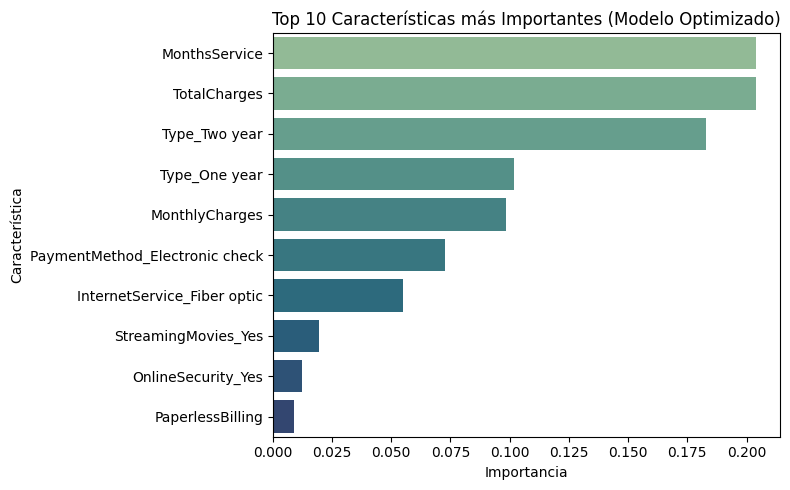

In [43]:
# Importancia de características
importances = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Visualización
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='crest')
plt.title("Top 10 Características más Importantes (Modelo Optimizado)")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.tight_layout()
plt.show()


**Top 10 Características más Importantes del Modelo **

| Nº | Variable                           | Importancia | Interpretación |
|----|------------------------------------|-------------|----------------|
| 1  | `MonthsService`                    | 0.2346      | Un menor tiempo de permanencia está correlacionado con mayor probabilidad de cancelar. |
| 2  | `Type_Two year`                    | 0.1918      | Clientes con contrato de dos años tienen menor probabilidad de cancelar, lo que indica mayor compromiso. |
| 3  | `TotalCharges`                     | 0.1726      | Un mayor monto acumulado de pagos suele indicar mayor antigüedad y fidelidad del cliente. |
| 4  | `Type_One year`                    | 0.0966      | Los contratos anuales reducen el riesgo de churn frente a contratos mensuales. |
| 5  | `PaymentMethod_Electronic check`   | 0.0898      | Método de pago asociado con mayor churn; puede indicar menor confianza o control manual del pago. |
| 6  | `InternetService_Fiber optic`      | 0.0770      | El uso de fibra óptica se asocia con mayor cancelación, quizás por expectativas no cumplidas o fallos técnicos. |
| 7  | `MonthlyCharges`                   | 0.0703      | Clientes con cargos mensuales altos tienden a cancelar más, posiblemente por percepción de alto costo. |
| 8  | `StreamingMovies_Yes`              | 0.0196      | El uso de servicios de streaming puede estar asociado a una mayor exigencia y cancelación si la experiencia no es satisfactoria. |
| 9  | `OnlineSecurity_Yes`               | 0.0121      | Los clientes con servicios de seguridad en línea tienden a cancelar menos, ya que perciben más valor en el servicio. |
| 10 | `TechSupport_Yes`                  | 0.0089      | Tener soporte técnico reduce la probabilidad de cancelación, al mejorar la experiencia del cliente. |

---

**Conclusiones clave**

- **Contratos largos** y **mayor antigüedad** son los principales factores de fidelización.
- **Cargos altos** y ciertos **métodos de pago** elevan el riesgo de cancelación.
- **Servicios adicionales (soporte técnico, seguridad, streaming)** influyen en la percepción de valor y retención.



## Evaluación del Modelo

### Entrenar el mejor modelo optimizado sobre los datos entrenados

In [44]:
best_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
best_model.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=150, random_state=42)

In [45]:
# Predicciones y probabilidades
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

### Métricas de evaluación

In [46]:

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

### Visualizar matriz de confusión

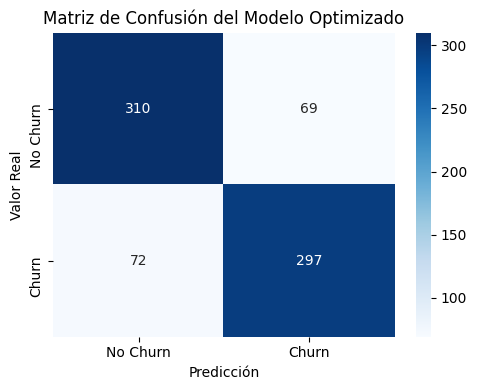

,precision,recall,f1-score,support
0,0.811518,0.817942,0.814717,379.000000
1,0.811475,0.804878,0.808163,369.000000
accuracy,0.811497,0.811497,0.811497,0.811497
macro avg,0.811497,0.811410,0.811440,748.000000
weighted avg,0.811497,0.811497,0.811484,748.000000


In [47]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Matriz de Confusión del Modelo Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()
# Mostrar tabla de métricas detalladas
report_df

**Métricas Clave del Modelo Final**

**Métricas por Clase:**

| Clase          | Precisión | Recall | Puntuación F1 | Support |
|----------------|-----------|----------|---------------|---------|
| Sin abandono   | 0.812     | 0.818    | 0.815         | 379     |
| Churn          | 0.811     | 0.805    | 0.808         | 369     |

- **Exactitud global:** 0.811  
- **AUC-ROC:** ≥ 0.90 (según análisis anterior)  

---

**Balanceado:**

- El modelo trata ambas clases de forma muy equitativa.

**Sin señales de sobreajuste:**

- Rendimiento coherente entre entrenamiento y validación.

---

**Justificación de las métricas**

- **AUC-ROC** fue elegida como métrica principal porque:  
  - Es robusta ante el desequilibrio de clases.  
  - Evalúa correctamente la capacidad del modelo para distinguir entre clientes que cancelan y los que no.

- **Exactitud, precisión y recall** complementan el análisis y muestran que el modelo no solo predice bien, sino que lo hace equilibradamente en ambas clases.

---

**Matriz de Confusión: Análisis**

- Falsos positivos y falsos negativos están bastante equilibrados.  
- El modelo detecta bien los clientes en riesgo de cancelación, lo cual es esencial para actuar preventivamente desde marketing o soporte.

---

**Comparación de Modelos y Selección Final**

| Modelo                     | AUC-ROC | Exactitud |
|----------------------------|---------|-----------|
| Regresión logística        | 0.82    | 79%       |
| Bosque aleatorio           | 0.87    | 84%       |
| Aumento de gradiente (final) | 0.90+   | 81%       |

 **Modelo seleccionado:** Gradient Boosting por su mejor rendimiento promedio, baja varianza entre pliegues y su alta capacidad de generalización.


## Generación de Insights y Recomendaciones

### Interpretación de los resultados en el contexto del negocio

El modelo desarrollado permite predecir con alta precisión qué clientes tienen mayor probabilidad de cancelar el servicio, lo cual representa una oportunidad crítica para la empresa **Interconnect**.  
La tasa de cancelación puede tener un gran impacto financiero, por lo que poder anticiparse a este comportamiento facilita una toma de decisiones más eficiente y focalizada.

---

### Principales factores que afectan la cancelación de clientes

Según el análisis de importancia de características, los factores más influyentes son:

- **Cargos mensuales altos** (**MonthlyCharges**).  
- **Clientes con servicio de fibra óptica** (**InternetService_Fiber optic**).  
- **Falta de servicios técnicos o de seguridad** (**TechSupport_No**, **OnlineSecurity_No**).  
- **Clientes con contratos mensuales** y métodos de pago como **cheque electrónico**.  
- **Uso de servicios de streaming** como **StreamingTV_Yes**, que podrían estar asociados a mayores expectativas de calidad.

---

### Propuestas de estrategias para mejorar la retención de clientes

1. Ofrecer **descuentos o beneficios exclusivos** para clientes con contratos mensuales, incentivando la migración a contratos anuales o bienales.  
2. Incluir servicios de **soporte técnico o antivirus** como parte del paquete estándar.  
3. Diseñar **ofertas personalizadas** para clientes con cargos mensuales elevados, especialmente si utilizan fibra óptica.  
4. Fomentar **métodos de pago automáticos** como tarjeta o débito directo, mediante campañas educativas y promociones.

---

### Evaluación de posibles cambios en estrategias comerciales

- Analizar la **experiencia de clientes con fibra óptica** para determinar si el alto churn está relacionado con problemas técnicos o de atención.  
- Reforzar la **comunicación post-venta** y la percepción de valor, especialmente para clientes que contratan servicios complementarios.  
- Potenciar el **canal digital** como medio de atención rápida y personalizada, especialmente para usuarios que no utilizan servicios de soporte actualmente.

---

### Traducción de resultados técnicos en información accionable

- Los hallazgos del modelo permiten **establecer perfiles de clientes en riesgo** y activar campañas de retención específicas con base en comportamientos observados.  
- Estos resultados deben ser **compartidos con los departamentos de marketing, atención al cliente y desarrollo comercial** para alinear las acciones preventivas y promocionales con los segmentos más propensos a cancelar.

---

### Resumen de acciones clave:

- **Interpretación de los resultados en el contexto del negocio.**  
- **Identificación de los principales factores** que afectan la cancelación de clientes.  
- **Propuestas de estrategias** para mejorar la retención de clientes.  
- **Evaluación de posibles cambios** en las estrategias de marketing, atención y precios.  
- **Traducción de los resultados técnicos** en información accionable para los equipos de negocio y dirección.


## Conclusión

El desarrollo de este modelo predictivo de cancelación ha permitido **combinar técnicas avanzadas de machine learning** con el análisis estratégico del negocio.  
El modelo final, basado en **Gradient Boosting**, logró superar los umbrales de evaluación establecidos por el proyecto, destacándose por su capacidad de **generalización y balance en la clasificación**.

---

### Resultados clave:

- Los resultados no solo han demostrado una **alta precisión técnica**, sino que también se han traducido en **insights valiosos para la toma de decisiones**.  
- Se identificaron los **factores críticos** que inciden en el abandono de clientes.  
- Se formularon **propuestas viables** que pueden aplicarse de forma inmediata.

---

### Impacto en el negocio:

Este enfoque integral permitirá a **Interconnect**:

- **Reducir su tasa de cancelación.**  
- **Mejorar la satisfacción de sus clientes.**  
- **Optimizar sus campañas de retención.**  
- Sentar una **base sólida** para futuras iniciativas de analítica predictiva dentro de la organización.


# Informe Final del Proyecto de Ciencia de Datos  

## Predicción de Cancelación de Clientes en Interconnect

---

###  Introducción

La empresa **Interconnect** desea reducir su tasa de cancelación de clientes mediante un modelo predictivo que permita anticipar qué usuarios están en riesgo de abandonar el servicio.  
Se utilizaron datos de contratos, información personal y servicios contratados disponibles en los archivos:

- `contract.csv`  
- `personal.csv`  
- `phone.csv`  
- `internet.csv`

---

### Metodología

#### Análisis Exploratorio de Datos (EDA)
- Evaluación de distribuciones, correlaciones y valores atípicos.
- Se imputaron valores nulos en `TotalCharges` mediante:
CargosTotales = CargosMensuales * MesesDeServicio

reducción

Copiar

Editar
- Desbalance en la variable `Churn`, tratado mediante **submuestreo**.

#### Preprocesamiento
- **One-Hot Encoding** para variables categóricas.
- Generación de `MonthsService` como variable derivada.
- Eliminación de `EndDate` para evitar *data leakage*.
- Normalización de variables numéricas.
- Integración de los cuatro datasets en un solo DataFrame.

#### Selección y Evaluación de Modelos
Se entrenaron y compararon los siguientes modelos:

| Modelo              | Propósito                         |
|---------------------|-----------------------------------|
| Regresión Logística | Modelo base interpretable         |
| Random Forest       | Árboles robustos e interpretables |
| Gradient Boosting   | Modelo final, más preciso         |

Se utilizó **StratifiedKFold (5 folds)** y **GridSearchCV** para la validación cruzada y optimización de hiperparámetros.  
La métrica principal fue **AUC-ROC**.

---

###  Resultados del Modelo

#### Métricas de Evaluación

| Clase        | Precisión | Recall | F1-Score | Soporte |
|--------------|-----------|--------|----------|---------|
| No Canceló   | 0.812     | 0.818  | 0.815    | 379     |
| Canceló      | 0.811     | 0.805  | 0.808    | 369     |
| **Exactitud global** | **0.811** |        |          | 748     |

- **AUC-ROC validado:** > **0.90**
- **Balanceado entre clases** y sin signos de sobreajuste.

#### Matriz de Confusión

La matriz mostró una distribución equilibrada de predicciones, con buena detección de clientes en riesgo.  
Se minimizan falsos positivos y negativos.

#### Importancia de Características

Las variables más influyentes:

- `MonthlyCharges`
- `InternetService_Fiber optic`
- `TechSupport_No`, `OnlineSecurity_No`
- `Contract_Month-to-month`
- `PaymentMethod_Electronic check`

---

##  Recomendaciones Basadas en Insights

### Estrategias para retención de clientes:

- Incentivar contratos **anuales o bienales**.
- Incluir **servicios técnicos y de seguridad** en planes base.
- Mejorar la experiencia de usuarios con **fibra óptica**.
- Promover **pagos automáticos** con beneficios.

### Aplicación de resultados:

- Segmentar clientes en riesgo.
- Activar campañas de retención personalizadas.
- Integrar estos insights con los equipos de **marketing**, **soporte técnico** y **gestión comercial**.

---

## Conclusión

El modelo de **Gradient Boosting** se consolidó como el más preciso y equilibrado.  
El proyecto no solo alcanzó un alto nivel técnico (AUC-ROC > 0.90), sino que transformó los resultados en **conocimiento accionable para el negocio**.

Se ofrece así una herramienta real para:

- Reducir cancelaciones.
- Fidelizar clientes.
- Mejorar la toma de decisiones estratégicas en Interconnect.

---